In [ ]:
from google.colab import drive
import zipfile
import os

MOUNT_DIR = '/content/drive'
DATA_DIR_SMALLER = '/content/drive/MyDrive/kaggle/DatasetSmaller.zip'
EXTRACTED_DIR = '/content/dataFolder'
# # Mount Google Drive
drive.mount(MOUNT_DIR, force_remount=False)
# # Path to the zip file in your Google Drive
zip_file_path = DATA_DIR_SMALLER

# # Directory to extract the contents
extracted_dir_path = EXTRACTED_DIR


def extract_data(extracted_dir_path):
#   # Extract the zip file
   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
       zip_ref.extractall(extracted_dir_path)

extract_data(extracted_dir_path)

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # print("Image size after transformation:", image.shape)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transform,
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [ ]:
data_foldername = 'dataFolder/folder'

dataset_path = os.path.join(os.getcwd(), data_foldername)
dataset = get_dataset(dataset_path)




# Extract HOG features from images
X = []
y = []
for img, label in dataset:
    img_np = np.array(img.permute(1, 2, 0))
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    X.append(hog_features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify=y, random_state=42)


# Create an instance of RandomForestClassifier and fit the model on the training data
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

print("Best Model Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Evaluate the performance of the best model on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report on Test Data:\n", report)

Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best CV Accuracy: 0.35124999999999995
Test Accuracy: 0.375
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.33      0.38      0.35        40
           1       0.44      0.38      0.41        40
           2       0.27      0.17      0.21        40
           3       0.39      0.50      0.44        40
           4       0.41      0.45      0.43        40

    accuracy                           0.38       200
   macro avg       0.37      0.38      0.37       200
weighted avg       0.37      0.38      0.37       200



In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Accuracy: 0.3750
Macro Precision: 0.3690
Macro Recall: 0.3750
Macro F1 Score: 0.3677


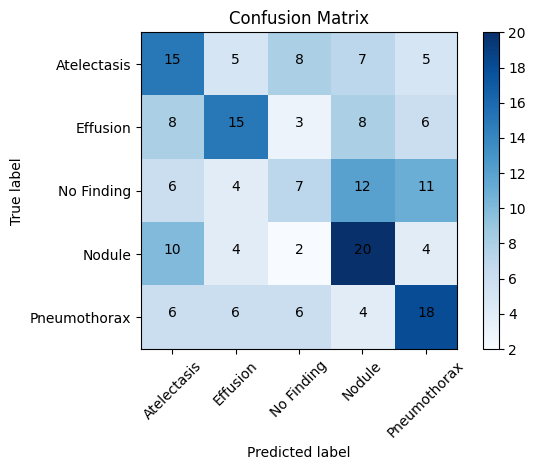

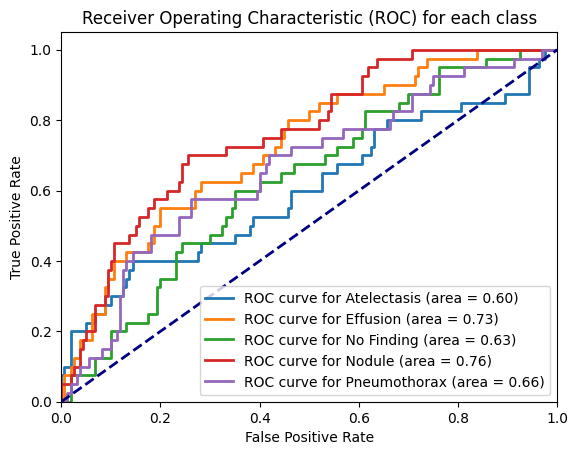

In [ ]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

metrics = {
    'accuracy': acc,
    'precision': pre,
    'recall': recall,
    'f1_score': f1
}


print("Accuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

#plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix)

from sklearn.preprocessing import label_binarize

#Convert y_test to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i],_  = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot ROC curves for each class
plt.figure()
lw = 2
classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for {} (area = {:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc="lower right")
plt.show()